# Inicio del proyecto y bibliotecas necesarias
En este proyecto, nuestro objetivo principal es desarrollar un modelo que pueda predecir los siguientes cinco días del Índice de Calidad del Aire (ICA). La elección de las herramientas y bibliotecas está guiada por la necesidad de procesar, analizar y modelar los datos de manera eficiente. Aquí, describimos brevemente cada biblioteca y su uso en este proyecto.

(1) pandas: Esta es una biblioteca extremadamente útil para la manipulación de datos en Python. Nos permite importar y manejar nuestros datos de una manera estructurada y eficiente. En este caso, lo utilizamos para leer los datos del ICA (con la función read_csv) y para manipulaciones de datos posteriores.

(2) numpy: Este paquete es fundamental para la computación numérica en Python. Se utiliza en todo el proyecto para operaciones matemáticas y manipulación de matrices.

(3) glob y os: Estas bibliotecas de Python se utilizan para realizar operaciones del sistema, como la manipulación de rutas de archivos y directorios. Nos permitirán cargar los archivos de datos necesarios para el análisis.

(4) matplotlib: Esta es una biblioteca muy popular para la visualización de datos en Python. Nos permitirá explorar nuestros datos gráficamente y visualizar los resultados de nuestras predicciones.

(5) math: Este módulo de Python proporciona funciones matemáticas definidas por el estándar de C. Lo utilizaremos para realizar cálculos necesarios en nuestros datos.

(6) keras: Es una biblioteca de alto nivel para la construcción de redes neuronales. Aquí, utilizamos Keras para construir y entrenar un modelo LSTM (Long Short-Term Memory), que es especialmente bueno para trabajar con series de tiempo, como nuestros datos de ICA.

(7) scikit-learn: Esta es una biblioteca de Python para el aprendizaje automático. Se utiliza para preprocesar nuestros datos (con MinMaxScaler) y para evaluar nuestro modelo final (con mean_squared_error). Es importante destacar que nuestro modelo se basará en las métricas de error cuadrático medio para medir su rendimiento.

La última línea de código es un comando para actualizar scikit-learn, una operación que solo debe realizarse si es necesario. Manténgalo comentado a menos que haya una necesidad específica de actualizar.

Ahora que hemos revisado las bibliotecas que vamos a utilizar, podemos proceder a cargar nuestros datos y comenzar el análisis exploratorio.

In [15]:
# IMPORTACIONES

# Bibliotecas para manipulación de datos
from pandas import read_csv
import pandas as pd
import numpy as np

# Bibliotecas para operaciones del sistema y manipulación de archivos
import glob
import os

# Bibliotecas para operaciones matemáticas y gráficas
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

# Bibliotecas para el modelado de redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Bibliotecas para preprocesamiento de datos y métricas de evaluación
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Crear y ajustar la red LSTM
from tensorflow.keras import optimizers

# Procesamiento de datos y limpieza
El primer paso para cualquier proyecto de ciencia de datos es la carga y limpieza de los datos. Estamos trabajando con un conjunto de datos de calidad del aire para la comuna de Pudahuel. En este fragmento de código, estamos realizando varias operaciones clave para preparar nuestros datos para el análisis y modelado.

(1) Fijar la semilla aleatoria: Esto es importante para asegurar la reproducibilidad de nuestro trabajo. Fijamos la semilla para la generación de números aleatorios utilizando np.random.seed(20773), lo que significa que cada vez que generamos números aleatorios, obtendremos la misma secuencia.

(2) Carga de datos y tratamiento de valores vacíos: Cargamos nuestros datos de calidad del aire utilizando pd.read_csv. Indicamos explícitamente que los espacios en blanco se consideren como valores NaN (Not a Number), lo que nos facilitará su manejo posterior.

(3) Interpolación y ajustes: Los datos de calidad del aire pueden tener valores faltantes. En lugar de eliminar estas filas, optamos por utilizar un método llamado interpolación para rellenar estos valores basándonos en los valores circundantes. Lo hacemos para 'pm10', 'o3' y 'so2'. Además, escalamos los valores de 'o3' dividiéndolos por 1000 para tener una escala similar a las otras variables.

(4) Tratamiento de fechas y ordenación: Convertimos la columna 'date' en un objeto datetime y ordenamos nuestros datos en orden descendente por fecha. Esto nos ayudará a analizar nuestros datos de forma cronológica y a entender mejor cómo han evolucionado las medidas de calidad del aire con el tiempo.

(5) Renombramiento de columnas: Cambiamos los nombres de las columnas para que sean más descriptivos y fáciles de entender.

(6) Impresión de valores 'so2': Finalmente, imprimimos los valores de 'so2' para asegurarnos de que nuestros datos se han procesado y limpiado correctamente.

Ahora que hemos preparado nuestros datos, estamos listos para avanzar con el análisis exploratorio y el modelado.

In [16]:
# Se fija la semilla para la generación de números aleatorios
np.random.seed(20773)

# Carga de datos con tratamiento de valores vacíos
pudahuel = pd.read_csv(
    'Pudahuel Data/pudahuel-air-quality.csv', 
    engine='python', 
    na_values=[' ']
)

# Interpolación de datos y ajustes
pudahuel[' pm10'] = pudahuel[' pm10'].interpolate()
pudahuel[' o3'] = pudahuel[' o3'].interpolate()
pudahuel[' o3'] = pudahuel[' o3'] / 1000
pudahuel[' so2'] = pudahuel[' so2'].interpolate(
    method='linear', limit_direction='both')

# Tratamiento de la fecha y ordenamiento
pudahuel['date'] = pd.to_datetime(pudahuel['date']).dt.date
pudahuel.sort_values('date', inplace=True, ascending=False)

# Renombramiento de columnas
pudahuel.columns = ['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

# Impresión de los valores de 'so2'
print(pudahuel['so2'])


27      59.0
26      59.0
25      59.0
24      59.0
23      59.0
        ... 
3342    57.0
3341    57.0
3340    57.0
3339    57.0
3455    57.0
Name: so2, Length: 3457, dtype: float64


# Unificación de múltiples conjuntos de datos
Nuestro análisis del Índice de Calidad del Aire no se limita a un solo archivo de datos. De hecho, tenemos varios archivos CSV que contienen información sobre diferentes aspectos relacionados con el clima y la calidad del aire. Estos archivos están organizados en carpetas separadas por categoría, y cada uno de ellos requiere un tratamiento específico en cuanto a las columnas que necesitamos para nuestro análisis.

Por lo tanto, creamos una función llamada juntar_datos_csv, que se encarga de unificar todos los datos necesarios en un solo DataFrame de Pandas. Esta función realiza las siguientes tareas:

(1) ***Lectura de todos los archivos CSV en una carpeta***: Utilizamos **_glob.glob_** para obtener una lista de todos los archivos CSV en la carpeta especificada.

(2) ***Lectura y almacenamiento de cada archivo CSV***: Recorremos la lista de archivos, leyendo cada uno en un DataFrame de Pandas. Solo tomamos las columnas especificadas en **_arreglo_columnas_**. Cada DataFrame se añade a una lista de DataFrames.

(3) ***Unión de los DataFrames***: Finalmente, utilizamos **_pd.concat_** para unir todos los DataFrames en la lista en un solo DataFrame.

Para demostrar cómo utilizar esta función, juntamos datos de varias carpetas como "Agua Caida", "Presion y Humedad", "Radiacion" y "Viento". Ahora tenemos conjuntos de datos unificados que contienen todas las columnas necesarias para nuestro análisis posterior.

In [17]:
def juntar_datos_csv(nombre_carpeta, arreglo_columnas):

    """
    Combina múltiples archivos CSV ubicados en una carpeta en un solo DataFrame.

    :param nombre_carpeta: La ruta de la carpeta que contiene los archivos CSV.
    :type nombre_carpeta: str
    :param arreglo_columnas: Lista de índices de columnas que se usarán del CSV.
    :type arreglo_columnas: list

    :return: Un DataFrame que combina los datos de todos los archivos CSV.
    :rtype: pd.DataFrame
    """
    
    # Obtiene la lista de todos los archivos que coinciden con el patrón
    csv_files = glob.glob(nombre_carpeta + "/*.csv")
    # Crea una lista para almacenar los DataFrames
    dfs = []

    # Lee cada archivo CSV y lo agrega a la lista de DataFrames
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, engine='python', sep=';',
                         usecols=arreglo_columnas)
        dfs.append(df)

    # Combina los DataFrames en uno solo
    return pd.concat(dfs)


# Ejemplo de uso de la función juntar_datos_csv
agua_caida = juntar_datos_csv("Pudahuel Data/Agua Caida", [3, 4])
presion_humedad = juntar_datos_csv("Pudahuel Data/Presion y Humedad",
                                   list(range(3, 10)))
radiacion = juntar_datos_csv("Pudahuel Data/Radiacion", [3, 4])
viento = juntar_datos_csv("Pudahuel Data/Viento", [3, 5, 6, 7, 8, 9])



## Formateo de data frames a datos por día

## Para datos de Agua Caída

El próximo paso en el preprocesamiento de nuestros datos implica transformar y reformatear nuestros datos para que estén en un formato útil para el análisis posterior y para alimentar a nuestro modelo de predicción.

Comenzamos por inspeccionar el DataFrame **_agua_caida_** con un simple **_print(agua_caida)_**. Esto nos da una idea general de cómo se estructuran nuestros datos.

A continuación, realizamos varias operaciones de transformación en el DataFrame agua_caida:

(1) ***Conversión de 'momento' a datetime***: La columna 'momento' contiene marcas de tiempo, pero para que Python las interprete correctamente como fechas y horas, necesitamos convertirlas explícitamente en objetos datetime. Lo hacemos utilizando la función pd.to_datetime.

(2) ***Añadir una columna 'date'***: Queremos poder agrupar nuestros datos por día. Sin embargo, la columna 'momento' contiene información tanto de la fecha como de la hora. Para facilitar el agrupamiento por día, añadimos una nueva columna 'date' que contiene solo la fecha. Extraemos la parte de la fecha de la columna 'momento' utilizando **_.dt.date_**.

(3) ***Agrupar por 'date' y sumar 'rrInst'*** : Finalmente, utilizamos **_groupby_** para agrupar nuestras observaciones por día. Para cada día, sumamos los valores de 'rrInst', que representan la cantidad de agua caída. Esto nos da una serie de pandas, **_agua_caida_f_**, que contiene la cantidad total de agua caída para cada día.

Estos pasos nos permiten consolidar nuestras observaciones por día, que es el nivel de granularidad que vamos a utilizar para nuestro análisis y modelado de series temporales.

In [18]:
# Imprimir el DataFrame "agua_caida"
print(agua_caida)

# Convertir la columna 'momento' a formato datetime
agua_caida['momento'] = pd.to_datetime(agua_caida['momento'])

# Agregar una columna "date" que contenga solo la fecha (sin la hora)
agua_caida['date'] = agua_caida['momento'].dt.date

# Realizar una agrupación por la columna 'date' y sumar los valores de la columna 'rrInst'
agua_caida_f = agua_caida.groupby('date')['rrInst'].sum()

                   momento  rrInst
0      2019-01-01 00:00:00     0.0
1      2019-01-01 00:01:00     0.0
2      2019-01-01 00:02:00     0.0
3      2019-01-01 00:03:00     0.0
4      2019-01-01 00:04:00     0.0
...                    ...     ...
44636  2023-05-31 23:56:00     0.0
44637  2023-05-31 23:57:00     0.0
44638  2023-05-31 23:58:00     0.0
44639  2023-05-31 23:59:00     0.0
44640  2023-06-01 00:00:00     0.0

[2447334 rows x 2 columns]


Para datos de Radiación

## Para datos de Radiación
Como hicimos con el DataFrame agua_caida, primero imprimimos el DataFrame radiacion para entender mejor su estructura. Seguidamente, convertimos la columna 'momento' en un objeto datetime y añadimos una columna 'date' que contiene únicamente la parte de la fecha de 'momento'. Por último, para cada día, obtenemos el valor máximo de 'radiacionGlobalInst', que representa la radiación solar medida. Esto nos da una serie de pandas, radiacion_f, que contiene el valor máximo de radiación solar para cada día.


In [19]:
# Imprimir el DataFrame "radiacion"
print(radiacion)

# Convertir la columna 'momento' a formato datetime
radiacion['momento'] = pd.to_datetime(radiacion['momento'])

# Agregar una columna "date" que contenga solo la fecha (sin la hora)
radiacion['date'] = radiacion['momento'].dt.date

# Obtener los valores máximos para cada día en las columnas especificadas
radiacion_f = radiacion.groupby('date')['radiacionGlobalInst'].max()

# Imprimir el resultado con los valores máximos por día de radiación
print(radiacion_f)


                   momento  radiacionGlobalInst
0      2019-05-01 00:00:00                  0.0
1      2019-05-01 00:01:00                  0.0
2      2019-05-01 00:02:00                  0.0
3      2019-05-01 00:03:00                  0.0
4      2019-05-01 00:04:00                  0.0
...                    ...                  ...
44636  2023-05-31 23:56:00                  0.0
44637  2023-05-31 23:57:00                  0.0
44638  2023-05-31 23:58:00                  0.0
44639  2023-05-31 23:59:00                  0.0
44640  2023-06-01 00:00:00                  0.0

[2142978 rows x 2 columns]
date
2019-05-01    770.6
2019-05-02    737.9
2019-05-03    781.2
2019-05-04    687.9
2019-05-05    699.3
              ...  
2023-05-28    510.3
2023-05-29    545.5
2023-05-30    464.4
2023-05-31    632.9
2023-06-01      0.0
Name: radiacionGlobalInst, Length: 1493, dtype: float64


## Para datos de Viento
El proceso para preparar el DataFrame viento es similar. Después de la conversión de 'momento' en datetime y la adición de la columna 'date', en lugar de tomar solo un valor para agrupar, seleccionamos varias columnas que representan diferentes aspectos del viento, como la velocidad y la dirección del viento en diferentes intervalos de tiempo. Para cada una de estas columnas, obtenemos el valor máximo para cada día. Esto nos da un DataFrame viento_f con los valores máximos diarios para cada medida del viento.

In [20]:
viento['momento'] = pd.to_datetime(viento['momento'])

# Agregar una columna "date" que contenga solo la fecha (sin la hora)
viento['date'] = viento['momento'].dt.date

# Obtener los valores máximos para cada día en las columnas especificadas
viento_f = viento.groupby('date')[['ffInst', 'dd02Minutos', 'ff02Minutos',
                                   'dd10Minutos', 'ff10Minutos']].max()
print(viento_f)


            ffInst  dd02Minutos  ff02Minutos  dd10Minutos  ff10Minutos
date                                                                  
2019-05-01    12.6        360.0         10.6        360.0          9.4
2019-05-02    10.5        360.0         10.0        360.0          9.7
2019-05-03    13.0        360.0          9.2        360.0          8.0
2019-05-04    15.6        360.0         12.1        358.0         11.3
2019-05-05    11.7        360.0          9.7        360.0          7.9
...            ...          ...          ...          ...          ...
2023-05-28    12.1        360.0          9.5        360.0          8.5
2023-05-29    12.4        360.0         11.3        358.0         10.4
2023-05-30    11.1        360.0          8.6        360.0          8.1
2023-05-31    14.4        360.0         13.5        360.0         12.7
2023-06-01     3.1        333.0          3.1        337.0          2.5

[1493 rows x 5 columns]


## Para datos de Presión y Humedad
Para el DataFrame presion_humedad, repetimos el proceso de conversión de 'momento' en datetime y adición de la columna 'date'. Sin embargo, en este caso, en lugar de tomar el valor máximo, calculamos el valor medio diario para un conjunto de medidas, incluyendo la humedad relativa ('hr'), la presión a nivel del mar ('p0'), y tres diferentes medidas de la presión atmosférica ('qfe1', 'qfe2', 'qff'). Al hacer esto, obtenemos un DataFrame presion_humedad_f que contiene los valores medios diarios para cada una de estas medidas.

Además, para la columna 'qfe2', realizamos una interpolación lineal para rellenar cualquier valor faltante. Este paso es necesario porque no todos los días pueden tener medidas disponibles para 'qfe2', pero no queremos dejar estos días fuera de nuestro análisis. En su lugar, interpolamos los valores faltantes basándonos en los días adyacentes, lo que nos da una estimación razonable del valor que 'qfe2' debería haber tenido en esos días.

Con todos estos pasos, hemos transformado y preparado nuestros DataFrames para un análisis más detallado y para alimentar a nuestro modelo de predicción.

In [21]:
presion_humedad['momento'] = pd.to_datetime(presion_humedad['momento'])

# Agregar una columna "date" que contenga solo la fecha (sin la hora)
presion_humedad['date'] = presion_humedad['momento'].dt.date

# Obtener los valores máximos para cada día en las columnas especificadas
presion_humedad_f = presion_humedad.groupby('date')[['hr', 'p0', 'qfe1', 'qfe2', 'qff']]\
                                .mean().reset_index()

presion_humedad_f['qfe2'] = presion_humedad_f['qfe2'].interpolate(
    method='linear', limit_direction='backward', axis=0)

print(presion_humedad_f)

            date         hr          p0        qfe1        qfe2          qff
0     2019-05-01  46.929167  962.261467  962.062257  960.771935  1017.741409
1     2019-05-02  35.030556  959.350694  959.150694  960.771935  1014.183472
2     2019-05-03  48.330556  957.909236  957.709236  960.771935  1012.564444
3     2019-05-04  72.917361  959.916806  959.716806  960.771935  1015.108403
4     2019-05-05  76.053472  962.057986  961.857986  960.771935  1017.477500
...          ...        ...         ...         ...         ...          ...
1488  2023-05-28  75.362500  963.748611  963.548931  963.728611  1020.074271
1489  2023-05-29  64.527778  962.370694  962.173764  962.350694  1017.812146
1490  2023-05-30  60.300000  962.908819  962.710889  962.888819  1018.731028
1491  2023-05-31  65.297222  963.702014  963.504757  963.682014  1019.509833
1492  2023-06-01  51.000000  961.600000  961.400000  961.580000  1017.070000

[1493 rows x 6 columns]


## Construccion Data Frame con todos los datos por fecha


## Integración de datos
Después de procesar y preparar cada DataFrame individualmente, el siguiente paso es combinarlos en un solo DataFrame para facilitar el análisis posterior y la alimentación de datos al modelo de predicción. Este proceso de integración de datos de diferentes fuentes se realiza utilizando la operación **_merge_** de pandas, que combina DataFrames basándose en una o varias columnas clave.

En este caso, usamos la columna 'date' como clave para combinar los datos. Esto tiene sentido ya que estamos interesados en analizar y predecir el ICA (Índice de Calidad del Aire) en función de varias medidas diarias, por lo tanto, queremos que todas las medidas para un día específico estén en la misma fila.

Comenzamos fusionando el DataFrame **_pudahuel_** con **_viento_f_**, luego el resultado con **_presion_humedad_f_**, después con **_agua_caida_f_**, y finalmente con **_radiacion_f_**. El resultado es un DataFrame, **_final_df_**, que contiene las medidas de todos los DataFrames para cada día.

Finalmente, imprimimos el DataFrame resultante y sus columnas para comprobar que todo ha ido bien y que todas las columnas que esperamos estén presentes. Este DataFrame integral será la base para nuestro análisis y modelado en los siguientes pasos.


In [22]:
# Fusionar los DataFrames 'pudahuel' y 'viento_f' en base a la columna 'date'
final_df = pudahuel.merge(viento_f, on='date')

# Fusionar el DataFrame 'final_df' con 'presion_humedad_f' en base a la columna 'date'
final_df = final_df.merge(presion_humedad_f, on='date')

# Fusionar el DataFrame 'final_df' con 'agua_caida_f' en base a la columna 'date'
final_df = final_df.merge(agua_caida_f, on='date')

# Fusionar el DataFrame 'final_df' con 'radiacion_f' en base a la columna 'date'
final_df = final_df.merge(radiacion_f, on='date')

# Imprimir el DataFrame final que contiene todas las fusiones de los DataFrames anteriores
print(final_df)

# Imprimir los nombres de las columnas del DataFrame final
print(final_df.columns)


            date   pm25   pm10     o3   no2        so2    co  ffInst  \
0     2023-06-01  153.0   89.0  0.014  40.0  59.000000  18.0     3.1   
1     2023-05-31  155.0   97.0  0.016  48.0  59.000000  19.0    14.4   
2     2023-05-30  134.0   97.0  0.018  49.0  59.000000  17.0    11.1   
3     2023-05-29  142.0   79.0  0.020  36.0  59.000000  13.0    12.4   
4     2023-05-28   90.0  120.0  0.008  27.0  59.000000  13.0    12.1   
...          ...    ...    ...    ...   ...        ...   ...     ...   
1486  2019-05-05   61.0   58.0  0.022  32.0  64.359885  13.0    11.7   
1487  2019-05-04   70.0   55.0  0.019  27.0  64.341547   8.0    15.6   
1488  2019-05-03  100.0   74.0  0.018  40.0  64.323209  10.0    13.0   
1489  2019-05-02  117.0   87.0  0.015  59.0  64.304871  15.0    10.5   
1490  2019-05-01   77.0   86.0  0.033  45.0  64.286533  16.0    12.6   

      dd02Minutos  ff02Minutos  dd10Minutos  ff10Minutos         hr  \
0           333.0          3.1        337.0          2.5  51.000

Los rangos y ponderaciones utilizados en el cálculo del Índice de Calidad del Aire de Santiago (ICAS) son definidos por la normativa chilena y están diseñados para evaluar la concentración de contaminantes atmosféricos y asignarles un valor numérico representativo de su nivel de riesgo para la salud humana y el medio ambiente.

Los rangos representan los límites o umbrales establecidos para cada contaminante. Por ejemplo, para el PM2.5, los rangos indican los intervalos de concentración que van desde niveles bajos hasta niveles peligrosos. Estos rangos pueden variar según el contaminante y la normativa vigente.

Las ponderaciones son los valores asignados a cada rango de concentración para determinar la contribución de cada contaminante al índice final. Estas ponderaciones suelen reflejar la importancia relativa de cada contaminante en términos de su impacto en la salud humana y el medio ambiente. Por ejemplo, se pueden asignar ponderaciones más altas a los contaminantes que tienen un mayor impacto en la calidad del aire y en la salud de las personas.

In [23]:
# Imprimir los nombres de las columnas del DataFrame final_df
print(final_df.columns)


# Función para calcular el AQI (Índice de Calidad del Aire)
def calcular_ica_polucion(cp, pollutant):

    """
    Calcula el Índice de Calidad del Aire (AQI) para un contaminante específico.

    :param cp: Concentración del contaminante.
    :type cp: float
    :param pollutant: Nombre del contaminante ('pm25', 'pm10', 'o3', 'no2', 'so2', 'co').
    :type pollutant: str

    :return: El valor del AQI calculado.
    :rtype: float
    """


    # Definir los puntos de interrupción y los rangos de AQI
    breakpoints = {
        'o3': [(0, 0.054), (0.055, 0.070), (0.071, 0.085), (0.086, 0.105),
                (0.106, 0.200), (0.201, 0.504)],
        'pm25': [(0, 12.0), (12.1, 35.4), (35.5, 55.4), (55.5, 150.4),
                 (150.5, 250.4), (250.5, 500.4)],
        'pm10': [(0, 54), (55, 154), (155, 254), (255, 354), (355, 424),
                 (425, 604)],
        'co': [(0, 4.4), (4.5, 9.4), (9.5, 12.4), (12.5, 15.4),
               (15.5, 30.4), (30.5, 50.4)],
        'so2': [(0, 35), (36, 75), (76, 185), (186, 304), (305, 604),
                (605, 1004)],
        'no2': [(0, 53), (54, 100), (101, 360), (361, 649),
                (650, 1249), (1250, 2049)]
    }
    rangos_ica = [(0, 50), (51, 100), (101, 150), (151, 200),
                  (201, 300), (301, 500)]
     # Calcular el AQI para el contaminante actual (pollutant) y el valor de concentración (cp)
    for i, (bp_lo, bp_hi) in enumerate(breakpoints[pollutant]):
        if bp_lo <= cp <= bp_hi:
            i_lo, i_hi = rangos_ica[i]
            ip = ((i_hi - i_lo) / (bp_hi - bp_lo)) * (cp - bp_lo) + i_lo
            return round(ip)
    return np.nan


def calcular_polucion(df):

    """
    Calcula el AQI (Índice de Calidad del Aire) para cada fila del DataFrame dado.

    :param df: DataFrame con los datos de contaminantes ('pm25', 'pm10', 'o3', 'no2', 'so2', 'co').
    :type df: pd.DataFrame

    :return: DataFrame con las columnas de AQI para cada contaminante y AQI general (ICA).
    :rtype: pd.DataFrame
    """

    #Calcular el AQI para cada contaminante y cada fila en el DataFrame
    for pollutant in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']:
        df[f'{pollutant}_ica'] = df[pollutant].apply(
            calcular_ica_polucion, pollutant=pollutant)


   # Calcular el AQI general (ICA) para cada fila en el DataFrame, tomando el valor máximo de los AQI de los contaminantes
    df['ICA'] = df[[f'{pollutant}_ica'
                                for pollutant in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']]].max(axis=1)
    return df


# Llamar a la función calcular_polucion para calcular el AQI para los contaminantes del DataFrame final_df
final_df = calcular_polucion(final_df)

# Supongamos que tienes un DataFrame llamado df que contiene los datos de pm25, pm10, o3, no2 y co
test = 10

# Filtrar y mostrar las filas del DataFrame final_df donde el ICA es mayor que el valor de prueba (test)
print(final_df.query("ICA > @test"))

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'ffInst',
       'dd02Minutos', 'ff02Minutos', 'dd10Minutos', 'ff10Minutos', 'hr', 'p0',
       'qfe1', 'qfe2', 'qff', 'rrInst', 'radiacionGlobalInst'],
      dtype='object')
            date   pm25   pm10     o3   no2        so2    co  ffInst  \
0     2023-06-01  153.0   89.0  0.014  40.0  59.000000  18.0     3.1   
1     2023-05-31  155.0   97.0  0.016  48.0  59.000000  19.0    14.4   
2     2023-05-30  134.0   97.0  0.018  49.0  59.000000  17.0    11.1   
3     2023-05-29  142.0   79.0  0.020  36.0  59.000000  13.0    12.4   
4     2023-05-28   90.0  120.0  0.008  27.0  59.000000  13.0    12.1   
...          ...    ...    ...    ...   ...        ...   ...     ...   
1486  2019-05-05   61.0   58.0  0.022  32.0  64.359885  13.0    11.7   
1487  2019-05-04   70.0   55.0  0.019  27.0  64.341547   8.0    15.6   
1488  2019-05-03  100.0   74.0  0.018  40.0  64.323209  10.0    13.0   
1489  2019-05-02  117.0   87.0  0.015  59.0  64.

### Creación de un dataset con intervalos de desplazamiento

La función **_create_interval_shifted_dataset_** se encarga de crear un nuevo DataFrame donde cada fila es un vector de características que contiene información de los días previos al día actual, así como la variable que deseamos predecir en el día actual.

Los argumentos de la función son:

**_df_**: el DataFrame original que contiene nuestros datos.
**_start_**: el comienzo del intervalo de días pasados que deseamos incluir en nuestras características.
**_end_**: el final del intervalo de días pasados que deseamos incluir en nuestras características.
**_keep_column_**: la columna que deseamos predecir.
En el interior de la función, se realiza lo siguiente:

Se clasifica el DataFrame original por fecha.
Se crean copias del DataFrame original desplazadas n días hacia atrás, con n en el intervalo de **_start_** a **_end_**. Cada una de estas copias se almacena en un diccionario **_dfs_auxiliares_**.
Se itera sobre cada fila del DataFrame original. Para cada fecha en el DataFrame original, se busca en cada uno de los DataFrames auxiliares la fila correspondiente a esa fecha. Si existe tal fila, se añaden sus valores a la nueva fila.
Finalmente, se añade la variable que deseamos predecic (de la columna **_keep_column_**) para la fecha actual, así como la fecha misma.
Al final, esta función devuelve un DataFrame en el que cada fila contiene información de los días previos al día actual, y la variable que deseamos predecir en el día actual. Este DataFrame estará preparado para ser usado en el entrenamiento de nuestro modelo.

In [25]:
# Funcion que crea un dataframe con los valores desplazados en un
# intervalo de tiempo de un data frame entregado

def create_interval_shifted_dataset(df, start, end, keep_column):

    """
    Crea un nuevo DataFrame con los valores desplazados en un intervalo de tiempo especificado
    a partir de un DataFrame dado.

    :param df: DataFrame original.
    :type df: pd.DataFrame
    :param start: Número de pasos de tiempo hacia atrás para comenzar a desplazar los valores.
    :type start: int
    :param end: Número de pasos de tiempo hacia atrás para finalizar el desplazamiento.
    :type end: int
    :param keep_column: Nombre de la columna que se mantendrá sin desplazamiento en el nuevo DataFrame.
    :type keep_column: str

    :return: Nuevo DataFrame con los valores desplazados.
    :rtype: pd.DataFrame
    """

    # Ordenar el DataFrame original por la columna 'date'
    df = df.sort_values(by='date')
    # Obtener la lista de columnas del DataFrame
    columns = df.columns.tolist()
    # Remover la columna 'keep_column' y la columna 'date' de la lista de columnas
    columns.remove(keep_column)
    columns.remove('date')

    # Crear un diccionario para almacenar DataFrames auxiliares desplazados
    dfs_auxiliares = {}

    # Crear DataFrames desplazados y almacenarlos en el diccionario 'dfs_auxiliares'
    for n in range(start, end + 1):
        dfs_auxiliares[n] = df.set_index('date').shift(n).reset_index()
    
    # Crear una lista para almacenar las filas del nuevo DataFrame
    new_data = []

    # Iterar sobre las filas del DataFrame original
    for i, row in df.iterrows():
        current_date = row['date']
        new_row = {}

        # Iterar sobre el rango de desplazamiento (start a end)
        for n in range(start, end + 1):

             # Obtener el DataFrame auxiliar desplazado para el paso de tiempo 'n'
            df_auxiliar = dfs_auxiliares[n]

            # Filtrar el DataFrame auxiliar para obtener la fila correspondiente a la fecha actual
            df_filtrado = df_auxiliar[df_auxiliar['date'] == current_date]

            # Si se encontró una fila correspondiente a la fecha actual en el DataFrame auxiliar
            if not df_filtrado.empty:

                # Copiar los valores desplazados de las columnas especificadas en el nuevo DataFrame
                for column in columns:
                    column_name = f"{column}(t-{n})"
                    new_row[column_name] = df_filtrado.at[df_filtrado.index[0], column]

        # Si se creó un nuevo registro en 'new_row', se agrega la columna 'keep_column' y la fecha al DataFrame final
        if new_row:
            new_row[keep_column + "(t)"] = row[keep_column]
            new_row['date'] = current_date

            # Se agrega el nuevo registro a la lista de filas del DataFrame final
            new_data.append(new_row)

    # Crear un nuevo DataFrame a partir de la lista de filas
    return pd.DataFrame(new_data)

### Preparación final del conjunto de datos para el modelo
En este bloque de código, preparamos el conjunto de datos final que será utilizado para entrenar y evaluar nuestro modelo de predicción del Índice de Calidad del Aire (ICA).

Primero, creamos una copia del DataFrame **_final_df_** que contiene todos nuestros datos recopilados y preprocesados. A esta copia la llamamos **_model_df_**.

Luego, eliminamos varias columnas que no son relevantes para nuestro modelo. Estas incluyen las columnas 'pm25_ica', 'pm10_ica', 'o3_ica', 'no2_ica', 'so2_ica', 'co_ica' y 'rrInst', las cuales representan los valores del ICA para diferentes componentes individuales y la cantidad de agua caída, respectivamente.

Después, llamamos a la función **_create_interval_shifted_dataset_** en nuestro DataFrame **_model_df_**. Esta función toma el DataFrame y crea un nuevo DataFrame donde cada fila contiene los datos de los últimos 5 a 10 días (según los argumentos proporcionados) y la variable que queremos predecir, en este caso, el ICA.

El resultado de esta función se almacena de nuevo en model_df. Luego, eliminamos cualquier fila que contenga valores nulos con el comando **_dropna()_**. Esto es para asegurarnos de que nuestro modelo solo se entrene con datos completos.

Finalmente, eliminamos la columna 'date' de **_model_df_** ya que la fecha no será una característica útil para nuestro modelo de predicción de series temporales. Lo que nos interesa son las relaciones entre las variables en los días previos y el ICA del día actual, no la fecha exacta en la que se recogieron estos datos.

Después de estos pasos, **_model_df_** está listo para ser utilizado en el entrenamiento de nuestro modelo.

In [26]:
# Crear una copia del DataFrame final_df para el modelo
model_df = final_df.copy()

# Imprimir las columnas del DataFrame model_df
print(model_df.columns)

# Eliminar columnas no deseadas del DataFrame model_df
model_df.drop(['pm25_ica', 'pm10_ica', 'o3_ica', 'no2_ica', 'so2_ica',
               'co_ica', 'rrInst'], axis=1, inplace=True)

# Crear un nuevo DataFrame model_df con valores desplazados
model_df = create_interval_shifted_dataset(model_df, 5, 10, 'ICA')


# Eliminar filas con valores NaN del DataFrame model_df
model_df = model_df.dropna()

# Imprimir el DataFrame model_df después de eliminar filas con valores NaN
print(model_df)

# Eliminar filas adicionales con valores NaN del DataFrame model_df
model_df.dropna(inplace=True)

# Eliminar la columna 'date' del DataFrame model_df, ya que no es necesaria para el modelo
model_df.drop(['date'], axis=1, inplace=True)


Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'ffInst',
       'dd02Minutos', 'ff02Minutos', 'dd10Minutos', 'ff10Minutos', 'hr', 'p0',
       'qfe1', 'qfe2', 'qff', 'rrInst', 'radiacionGlobalInst', 'pm25_ica',
       'pm10_ica', 'o3_ica', 'no2_ica', 'so2_ica', 'co_ica', 'ICA'],
      dtype='object')
      pm25(t-5)  pm10(t-5)  o3(t-5)  no2(t-5)   so2(t-5)  co(t-5)  \
10         72.0       72.0    0.017      47.0  64.378223     12.0   
11         88.0       66.0    0.020      29.0  64.396562      6.0   
12         80.0       55.0    0.013      26.0  64.414900      6.0   
13         79.0       46.0    0.019      27.0  64.433238      7.0   
14         71.0       65.0    0.024      44.0  64.451576     12.0   
...         ...        ...      ...       ...        ...      ...   
1486       80.0       78.0    0.005      30.0  59.000000     15.0   
1487      121.0       59.0    0.003      23.0  59.000000     14.0   
1488       92.0       73.0    0.005      27.0  59.000000     13.0  

### Normalización de los datos
En este paso, escalamos nuestras características para que todas estén en el mismo rango. Esta es una práctica común en el aprendizaje automático para ayudar a ciertos algoritmos a converger más rápido y mejorar su rendimiento.

En nuestro caso, utilizamos el **_MinMaxScaler_** de **_sklearn_**, que escala las características de modo que todos los valores estén en el rango de 0 a 1.

Primero, creamos un objeto **_MinMaxScaler_** y lo almacenamos en la variable **_scaler_**. Luego, imprimimos la forma del DataFrame **_model_df_** para tener una idea de su tamaño antes de la transformación.

Luego, ajustamos y transformamos los datos en **_model_df_** con el método **_fit_transform_** de **_scaler_**. Esto calcula el mínimo y el máximo de cada característica (el ajuste) y luego aplica la transformación (resta el mínimo y divide por el rango, es decir, máximo menos mínimo) para escalar los datos al rango de 0 a 1.

Finalmente, volvemos a imprimir la forma de **_model_df_** después de la transformación para confirmar que la forma del DataFrame no ha cambiado después de la normalización.

In [27]:
# Crear un objeto MinMaxScaler para escalar los datos del DataFrame model_df al rango (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Imprimir la forma (dimensiones) del DataFrame model_df antes de aplicar el escalado
print(model_df.shape)

# Aplicar el escalado a los datos del DataFrame model_df
model_df = scaler.fit_transform(model_df)

# Imprimir la forma (dimensiones) del DataFrame model_df después de aplicar el escalado
print(model_df.shape)

(1372, 103)
(1372, 103)


### División de los Datos en Conjuntos de Entrenamiento y Prueba
En la mayoría de las aplicaciones de aprendizaje automático, es importante dividir nuestro conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento se utiliza para entrenar nuestro modelo, y el conjunto de prueba se utiliza para evaluar qué tan bien ha aprendido nuestro modelo a partir de los datos de entrenamiento.

En este caso, estamos usando el 80% de nuestros datos para el entrenamiento (**_train_**) y el 20% restante para las pruebas (**_test_**).

Primero, calculamos el tamaño de nuestro conjunto de entrenamiento (**_train_size_**) tomando el 80% del número total de observaciones en **_model_df_**. A continuación, calculamos el tamaño del conjunto de prueba (**_test_size_**) restando **_train_size_** del número total de observaciones.

Luego, dividimos **_model_df_** en dos subconjuntos: **_train_**, que contiene las primeras **_train_size_** observaciones, y **_test_**, que contiene el resto.

Finalmente, imprimimos el número de observaciones en train y test para confirmar que se han dividido correctamente.


In [28]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_size = int(len(model_df) * 0.8)
test_size = len(model_df) - train_size

# Obtener los conjuntos de entrenamiento y prueba mediante la división de model_df
train, test = model_df[0:train_size], model_df[train_size:len(model_df)]

# Imprimir la longitud de los conjuntos de entrenamiento y prueba
print(len(train), len(test))

1097 275


In [29]:
# Separar las características (train_x) de las etiquetas (train_y) del conjunto de entrenamiento
train_x, train_y = train[:, :-1], train[:, -1]
print(train_x.shape, train_y.shape)

# Obtener las características (test_x) y etiquetas (test_y) del conjunto de prueba
test_x, test_y = test[:, :-1], test[:, -1]
print(test.shape)

(1097, 102) (1097,)
(275, 103)


### Preparación de Datos para el Modelo LSTM y Visualización de Datos
Las redes LSTM requieren que los datos de entrada tengan una cierta estructura, en concreto, necesitan que los datos estén en un formato tridimensional: [muestras, pasos de tiempo, características].

En nuestro caso, remodelamos nuestros conjuntos de datos **_train_x_** y **_test_x_** para cumplir con este requisito utilizando el método **_.reshape()_**. Las dimensiones son las siguientes:

La primera dimensión es el número de muestras, que es el número total de observaciones en el conjunto de datos.
La segunda dimensión es el número de pasos de tiempo, que es el número de observaciones utilizadas para predecir la siguiente observación.
La tercera dimensión es el número de características, que es el número de variables que estamos utilizando para predecir.

Además, imprimimos las dimensiones de **_train_x_**, **_train_y_**, **_test_x_**, y **_test_y_** para confirmar que se han remodelado correctamente. También imprimimos las dimensiones de **_train_x_** para confirmar que los datos se han remodelado al formato requerido por LSTM.

Finalmente, graficamos un ejemplo de los datos de entrenamiento (**_train_x_**) y los datos de prueba (**_test_x_**).

(1097, 102, 1) (1097,) (275, 102, 1) (275,)
102 1


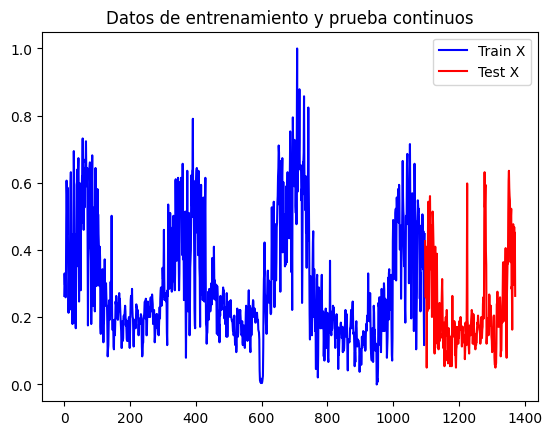

In [30]:
# Cambiar la forma (reshape) de train_x y test_x
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], train_x.shape[1], 1))

# Imprimir las dimensiones de train_x, train_y, test_x y test_y
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# Imprimir el número de pasos de tiempo (time steps) y el número de características (features) de train_x
print(train_x.shape[1], train_x.shape[2])


# Graficar datos de entrenamiento y prueba continuamente
plt.plot(range(train_x.shape[0]), train_x[:, 0, 0], label='Train X', color='blue')
plt.plot(range(train_x.shape[0], train_x.shape[0] + test_x.shape[0]), test_x[:, 0, 0], label='Test X', color='red')
plt.title('Datos de entrenamiento y prueba continuos')
plt.legend()
plt.show()


### Crear y entrenar modelo
Ahora, vamos a crear y ajustar nuestra red neuronal. El modelo es un modelo secuencial, que es apropiado para un stack de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida.

Primero, agregamos tres capas LSTM con 32 unidades. La capa LSTM (Long Short Term Memory) es un tipo de capa recurrente que es adecuada para procesar series temporales. La entrada a la capa LSTM es el conjunto de entrenamiento que reformateamos en pasos anteriores.
Luego, agregamos una capa densa con una sola unidad que servirá como nuestra capa de salida. Una capa densa es una capa de red neuronal en la que todas las neuronas están conectadas a todas las neuronas de la capa anterior.

Finalmente, compilamos nuestro modelo usando el optimizador 'adam' y la pérdida de 'mean_squared_error' ya que nuestro problema es de regresión.

In [31]:
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True,
               input_shape=(102, 1)))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32))  # return a single vector of dimension 32
model2.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.009)
model2.compile(loss='mean_squared_error', optimizer=adam)

In [32]:
#model2
history  = model2.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(test_x, test_y), verbose=1, shuffle=False)

Epoch 1/100
35/35 [==============================] - 8s 99ms/step - loss: 0.0655 - val_loss: 0.0115
Epoch 2/100
35/35 [==============================] - 2s 68ms/step - loss: 0.0215 - val_loss: 0.0094
Epoch 3/100
35/35 [==============================] - 2s 67ms/step - loss: 0.0204 - val_loss: 0.0086
Epoch 4/100
35/35 [==============================] - 2s 68ms/step - loss: 0.0206 - val_loss: 0.0086
Epoch 5/100
35/35 [==============================] - 2s 71ms/step - loss: 0.0205 - val_loss: 0.0087
Epoch 6/100
35/35 [==============================] - 2s 67ms/step - loss: 0.0204 - val_loss: 0.0088
Epoch 7/100
35/35 [==============================] - 2s 69ms/step - loss: 0.0201 - val_loss: 0.0089
Epoch 8/100
35/35 [==============================] - 2s 67ms/step - loss: 0.0199 - val_loss: 0.0091
Epoch 9/100
35/35 [==============================] - 2s 68ms/step - loss: 0.0197 - val_loss: 0.0094
Epoch 10/100
35/35 [==============================] - 2s 70ms/step - loss: 0.0195 - val_loss: 0.0094

In [33]:
train_predict = model2.predict(train_x)
test_predict = model2.predict(test_x)


9/9 [==============================] - 0s 22ms/step


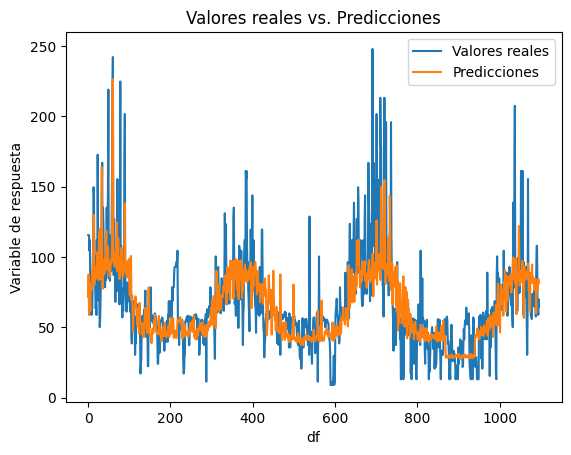

Train Score: 23.60 RMSE


In [34]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]))
train_predict = np.concatenate((train_predict, train_x), axis=1)
train_predict = scaler.inverse_transform(train_predict)
train_predict = train_predict[:, 0]

train_y = train_y.reshape(len(train_y), 1)
data_entrenamiento_y = np.concatenate((train_y, train_x), axis=1)
data_entrenamiento_y = scaler.inverse_transform(data_entrenamiento_y)
data_entrenamiento_y = data_entrenamiento_y[:, 0]

# Graficar los valores reales
plt.plot(data_entrenamiento_y, label='Valores reales')

# Graficar las predicciones
plt.plot(train_predict, label='Predicciones')

plt.xlabel('df')
plt.ylabel('Variable de respuesta')
plt.title('Valores reales vs. Predicciones')
plt.legend()
plt.show()

train_score = math.sqrt(mean_squared_error(data_entrenamiento_y, train_predict))
print('Train Score: %.2f RMSE' % (train_score))

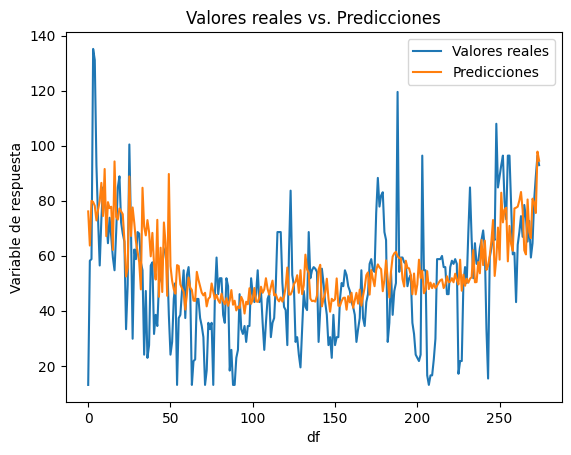

Test Score: 19.04 RMSE


In [35]:
# invert predictions
# Arreglo shatgipti
#pred_prueba_y = test_predict.reshape(test_predict.shape[0], test_predict.shape[1])
test_X = test_x.reshape((test_x.shape[0], test_x.shape[1]))
pred_prueba_y = np.concatenate((test_predict, test_X), axis=1)
pred_prueba_y = scaler.inverse_transform(pred_prueba_y)
pred_prueba_y = pred_prueba_y[:, 0]

test_Y = test_y.reshape(len(test_y), 1)
data_prueba_y = np.concatenate((test_Y, test_X), axis=1)
data_prueba_y = scaler.inverse_transform(data_prueba_y)
data_prueba_y = data_prueba_y[:, 0]

# Graficar los valores reales
plt.plot(data_prueba_y, label='Valores reales')

# Graficar las predicciones
plt.plot(pred_prueba_y, label='Predicciones')

plt.xlabel('df')
plt.ylabel('Variable de respuesta')
plt.title('Valores reales vs. Predicciones')
plt.legend()
plt.show()


test_score = math.sqrt(mean_squared_error(data_prueba_y, pred_prueba_y))
print('Test Score: %.2f RMSE' % (test_score))